<h1 align='center'>Image Super-Resolution Using Deep Convolutional Networks</center>


This is the implementation of SRCNN.

More details can be found [here](http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html)

# Load library 

In [119]:
from keras.datasets import mnist
from keras.layers import Reshape,Dense
import numpy as np
from keras.layers import UpSampling2D,MaxPool2D,Conv2D,Activation,Dropout,BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy import ndimage as nd
import myplot
from skimage.measure import compare_psnr,compare_ssim
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import ycbcr2rgb,rgb2ycbcr
from scipy.misc import imread
# from skimage.color import rgb2 

def psnr(Original_test,test_image,interpolation):
    psnr_value = []
    for O_image,SR_image in zip(Original_test,test_image):
        imrecov = imresize(SR_image,size=(28,28),interp=interpolation)
        psnr_value.append(compare_psnr(O_image,imrecov.astype('float64')))
        return np.array(psnr_value).mean() 

# Load data 

In [2]:
down=np.load('BSD100-SRF_2.npz')
LR_images = down['LR']
HR_images = down['HR']
LR_images=LR_images.astype('uint8')
HR_images=HR_images.astype('uint8')

# Visualise HR and LR in RBG

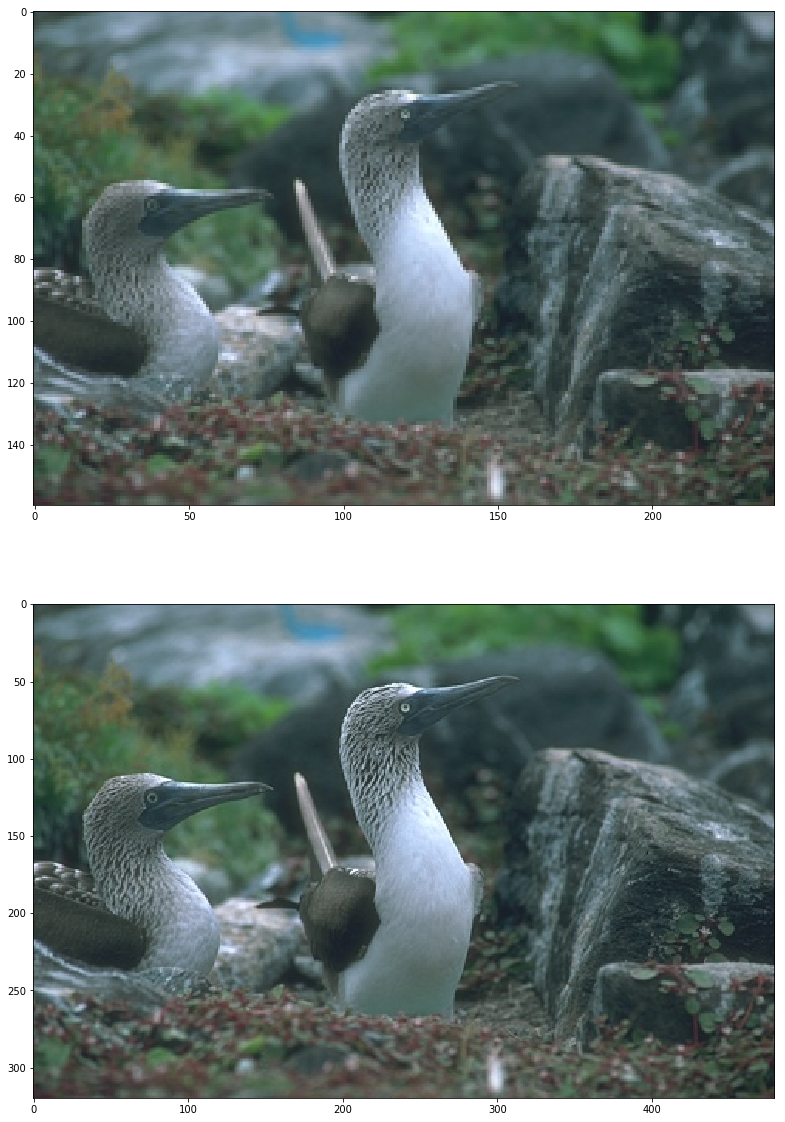

In [3]:
plt.figure(figsize=(30,20))
plt.subplot(211)
plt.imshow((LR_images[0]))
plt.subplot(212)
plt.imshow((HR_images[0]))
plt.show()

In [4]:
#Original_image = np.reshape(LR_images,(LR_images.shape[0],LR_images.shape[1],LR_images.shape[2],1))
print 'shape of original image is %d x %d  x%d  x%d ' %HR_images.shape
#LR_mnist = np.reshape(LR_mnist,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2],1))
print 'shape of downsample image is  %d x %d  x%d  x%d  ' %LR_images.shape 

shape of original image is 77 x 320  x480  x3 
shape of downsample image is  77 x 160  x240  x3  


# Bicubic interplation 

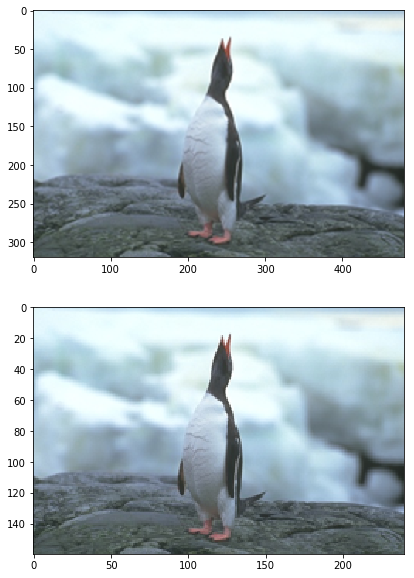

In [5]:
temp_bicubic= []
for index in tqdm(range(len(LR_images))):
    temp_bicubic.append(imresize(LR_images[index],size=2.0,interp='bicubic'))
bicubic_LR =np.array(temp_bicubic)
# bicubic_mnist = np.reshape(bicubic_mnist,(bicubic_mnist.shape[0],bicubic_mnist.shape[1],bicubic_mnist.shape[2],1))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(bicubic_LR[2])
plt.subplot(212)
plt.imshow(LR_images[2])
plt.show()

## Convert RGB to YCbCr 

In [6]:
value_of_L =[]
value_of_H = []

for L_image,H_image in tqdm(zip(bicubic_LR,HR_images)):
    value_of_L.append(rgb2ycbcr(L_image))
    value_of_H.append(rgb2ycbcr(H_image))

HR_ycbcr= np.stack(value_of_H)
LR_ycbcr= np.stack(value_of_L)

# Visualise single channel in YCBCR

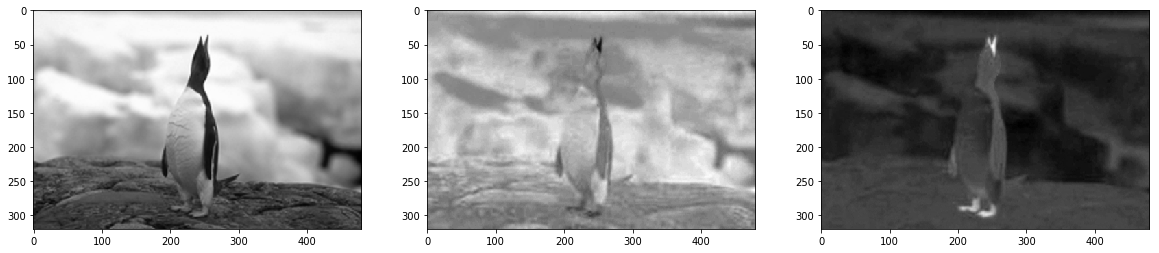

In [7]:
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.imshow(LR_ycbcr[2,:,:,0],cmap='gray')
plt.subplot(132)
plt.imshow(LR_ycbcr[2,:,:,1],cmap='gray')
plt.subplot(133)
plt.imshow(LR_ycbcr[2,:,:,2],cmap='gray')
plt.show()

# Traditional method of recover image from low resolution 

imresize support a lot of image Interpolation methods there I examed 5 of them. 
They are:  
- nearest 
- lanczors
- bilinear 
- cubic 
- bicubic 

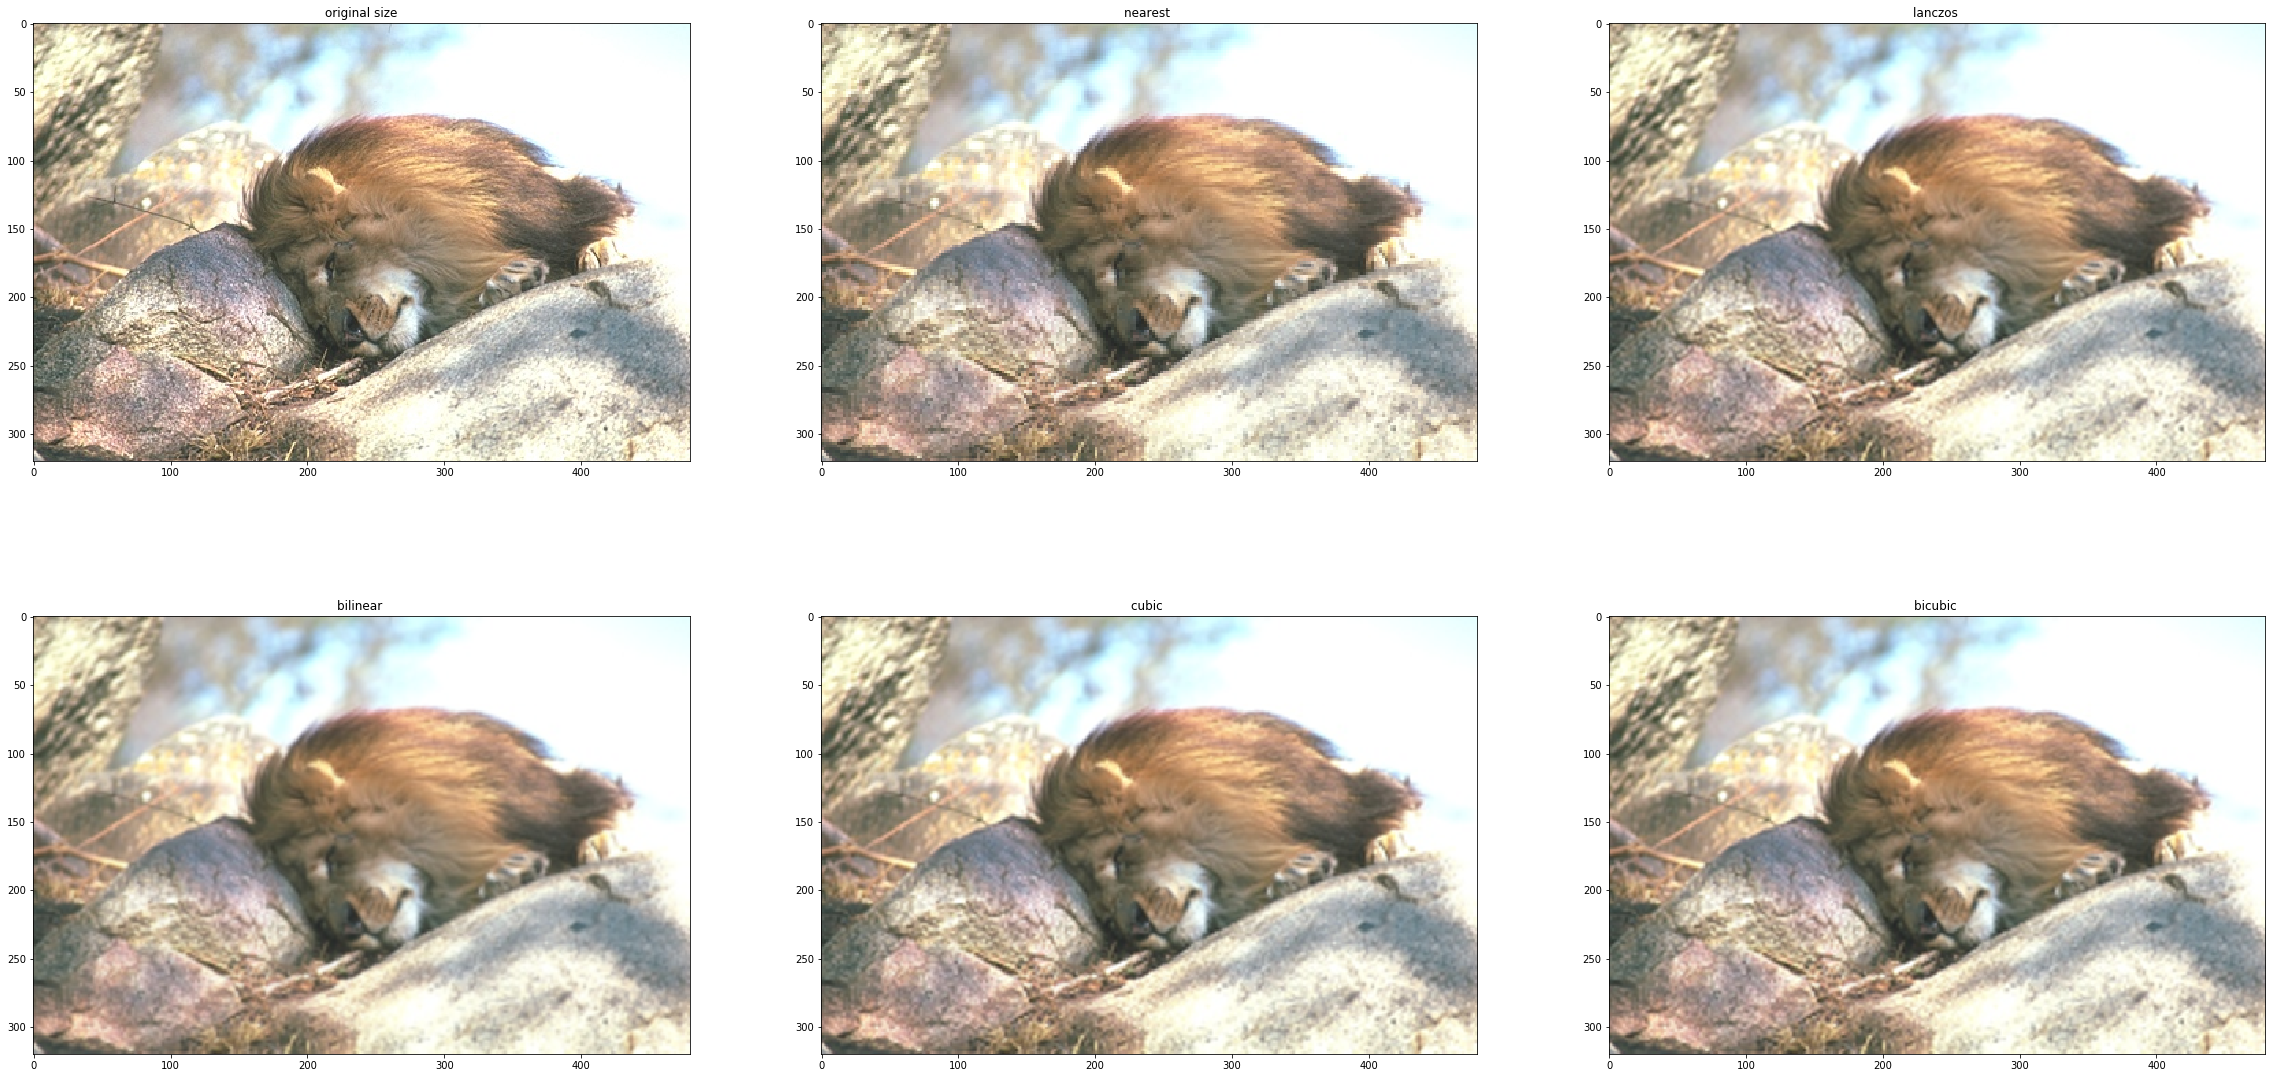

In [8]:
#bicubic_mnist = np.reshape(LR_images,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2]))
image_index=1
#Img_HR = ycbcr2rgb(HR_images[image_index])
#Img_LR = ycbcr2rgb(HR_images[image_index])
plt.figure(figsize=(40,20))
myplot.plot_comparison(O_image=ycbcr2rgb(value_of_H[image_index]),down_image=LR_images[image_index])

# The input is the bicubic-low-resolution image , the output is the original image

Before generate the model. It is very important to normalise the image . 
The SRCNN is only operated in Y channel. Only Y channel is normalised and the CNN is take 1 color channel is input.
The original value of image is between 0 and 255, I will make it between -1 and 1. 


In [9]:
LR_Y_channel = (LR_ycbcr[:,:,:,0]-127.5)/128
HR_Y_channel =(HR_ycbcr[:,:,:,0]-127.5)/128
# bicubic_LR=(bicubic_LR-127.5)/128
LR_Y_channel = np.reshape(LR_Y_channel,(LR_Y_channel.shape[0],LR_Y_channel.shape[1],LR_Y_channel.shape[2],1))

HR_Y_channel = np.reshape(HR_Y_channel,(HR_Y_channel.shape[0],HR_Y_channel.shape[1],HR_Y_channel.shape[2],1))
print 'Max of LR_mnist is %f, Min of LR_mnist is %f' %(LR_Y_channel.max() ,LR_Y_channel.min() )
print 'Max of Original_image is %f, Min of Original_image is %f' %(LR_Y_channel.max() ,LR_Y_channel.min() )


Max of LR_mnist is 0.839844, Min of LR_mnist is -0.871094
Max of Original_image is 0.839844, Min of Original_image is -0.871094


In [10]:
G=Sequential()
G.add(Conv2D(64,(9,9),padding='same',input_shape=(None,None,1)))
#G.add(Conv2D(16,(5,5),padding='same'))
#G.add(Dropout(0.9))
G.add(Activation('relu')) 
G.add(Conv2D(32,(1,1),padding='same'))
G.add(Activation('relu'))
# G.add(BatchNormalization())
G.add(Conv2D(1,(5,5),padding='same'))
#G.add(Activation('sigmoid'))
G.summary()

G.compile(loss='mse',optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    5248      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 1)     801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [11]:
G.fit(x=LR_Y_channel,y=HR_Y_channel,batch_size=8,epochs=20)

Epoch 1/20
77/77 [==============================] - 7s - loss: 0.0563      
Epoch 2/20
77/77 [==============================] - 4s - loss: 0.0215     

In [12]:
G.save('SRCNN_ycbcr.h5')

# Benchmark 

In [97]:
index = 20
Image_to_test = LR_ycbcr[index].copy()
Image_to_test_y_channel = Image_to_test[:,:,0]
Image_to_test_y_channel =(Image_to_test_y_channel-127.5)/128
Image_to_test_y_channel = np.reshape(Image_to_test_y_channel,(1,Image_to_test_y_channel.shape[0],Image_to_test_y_channel.shape[1],1))
Image_to_test_y_channel_pred= G.predict(x=Image_to_test_y_channel)
Image_to_test_y_channel_pred = np.reshape(Image_to_test_y_channel_pred,(Image_to_test_y_channel_pred.shape[1],Image_to_test_y_channel_pred.shape[2]))
Image_to_test_y_channel = np.reshape(Image_to_test_y_channel,(Image_to_test_y_channel.shape[1],Image_to_test_y_channel.shape[2]))

Image_to_test_y_channel_pred=(Image_to_test_y_channel_pred*128)+127.5

#Image_to_test_y_channel_pred[Image_to_test_y_channel_pred>255]=255
#Image_to_test_y_channel_pred[Image_to_test_y_channel_pred<0]=0


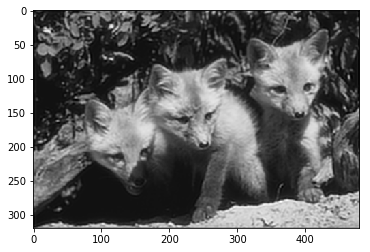

In [98]:
plt.imshow(Image_to_test_y_channel_pred,cmap='gray')
plt.show()

In [99]:
Image_to_test_y_channel_pred.max()

251.18057

In [100]:
Image_to_test[:,:,0]=Image_to_test_y_channel_pred

In [101]:
HR_Y_channel.shape

(77, 320, 480, 1)

In [106]:
exam_image_RGB = ycbcr2rgb(Image_to_test)

In [107]:
exam_image_RGB[exam_image_RGB>1]=1
exam_image_RGB[exam_image_RGB<0]=0

In [108]:
exam_image_RGB *=255
exam_image_RGB.astype('uint8')

array([[[ 95,  99,  89],
        [ 76,  79,  69],
        [ 56,  62,  51],
        ..., 
        [ 50,  56,  50],
        [ 51,  58,  52],
        [ 70,  77,  71]],

       [[ 78,  83,  70],
        [ 38,  42,  30],
        [ 16,  23,   9],
        ..., 
        [  0,   5,   0],
        [ 10,  17,  11],
        [ 46,  53,  47]],

       [[ 66,  73,  55],
        [ 28,  35,  18],
        [  4,  12,   0],
        ..., 
        [  0,   0,   0],
        [  2,   7,   3],
        [ 40,  45,  41]],

       ..., 
       [[ 51,  55,  48],
        [ 18,  22,  14],
        [  0,   1,   0],
        ..., 
        [221, 200, 140],
        [200, 178, 119],
        [175, 153,  93]],

       [[ 54,  57,  49],
        [ 29,  32,  23],
        [ 10,  13,   0],
        ..., 
        [231, 210, 150],
        [208, 188, 126],
        [181, 160,  99]],

       [[ 71,  74,  65],
        [ 56,  59,  49],
        [ 49,  52,  38],
        ..., 
        [186, 166, 105],
        [170, 151,  88],
        [153, 133,

In [109]:
exam_image_RGB.max()

255.0

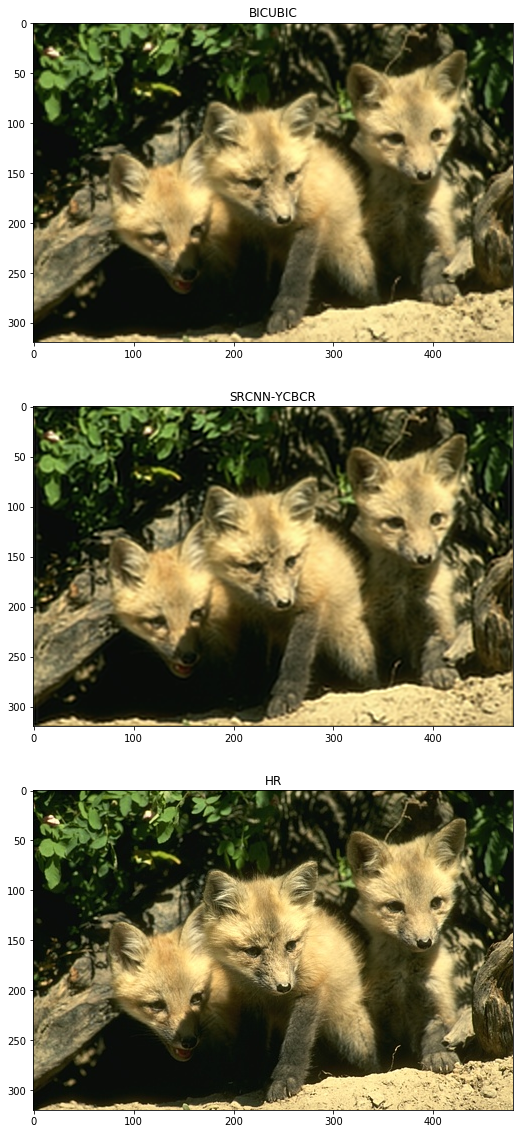

In [225]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.title('BICUBIC')
plt.imshow(ycbcr2rgb(LR_ycbcr[index]))

plt.subplot(312)
plt.title('SRCNN-YCBCR')
plt.imshow(exam_image_RGB.astype('uint8'))



plt.subplot(313)
plt.title('HR')
plt.imshow(HR_images[20])


plt.savefig('BSD100_SRF_4_YCBCR_20')
plt.show()
plt.close()

In [113]:
compare_psnr(HR_images[index],exam_image_RGB.astype('uint8'))

28.224334978222888

In [114]:
compare_psnr(HR_images[index],ycbcr2rgb(LR_ycbcr[index]).astype('uint8'))

7.509319244082981

In [231]:
mypath = './data/Set5/image_SRF_4/img_001_SRF_4_HR.png'
value_truth=imread(mypath)
mypath = './data/Set5/image_SRF_4/img_001_SRF_4_LR.png'
value_pred=imread(mypath)
value_pred_bi=imresize(arr=value_pred,size=4.0,interp='bicubic')
input_YCBCR = rgb2ycbcr(value_pred_bi)
input_Y = input_YCBCR[:,:,0]
input_Y = (input_Y-127.5)/128
input_Y=np.reshape(input_Y,(1,input_Y.shape[0],input_Y.shape[1],1))

predict_SR= G.predict(x=input_Y)
predict_SR=predict_SR*128+127.5

In [232]:
input_Y.shape

(1, 512, 512, 1)

In [233]:

predict_SR=predict_SR.astype('uint8')
input_YCBCR[:,:,0]=predict_SR[0,:,:,0]

input_RGB =ycbcr2rgb(input_YCBCR)
input_RGB*=255
input_RGB[input_RGB>255]=255
input_RGB[input_RGB<0]=0

In [234]:
input_RGB.max()

255.0

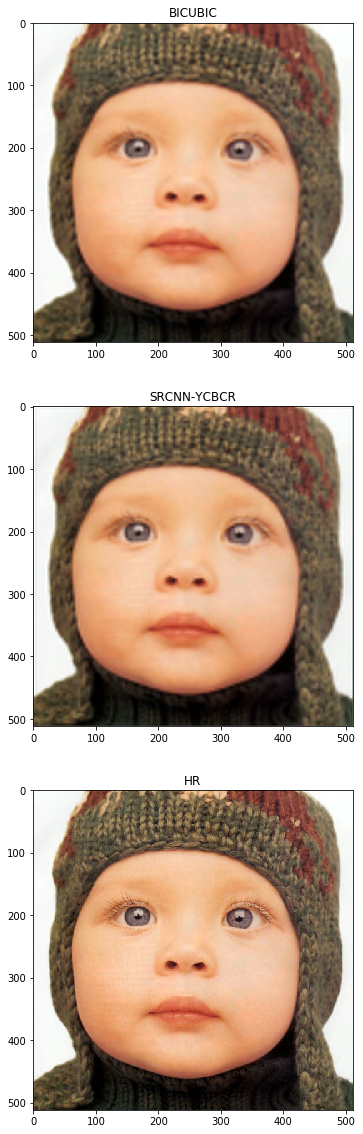

In [235]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.title('BICUBIC')
plt.imshow(value_pred_bi)

plt.subplot(312)
plt.title('SRCNN-YCBCR')
plt.imshow(input_RGB.astype('uint8'))



plt.subplot(313)
plt.title('HR')
plt.imshow(value_truth)


plt.savefig('SET5_SRF_4_YCBCR_04')
plt.show()
plt.close()

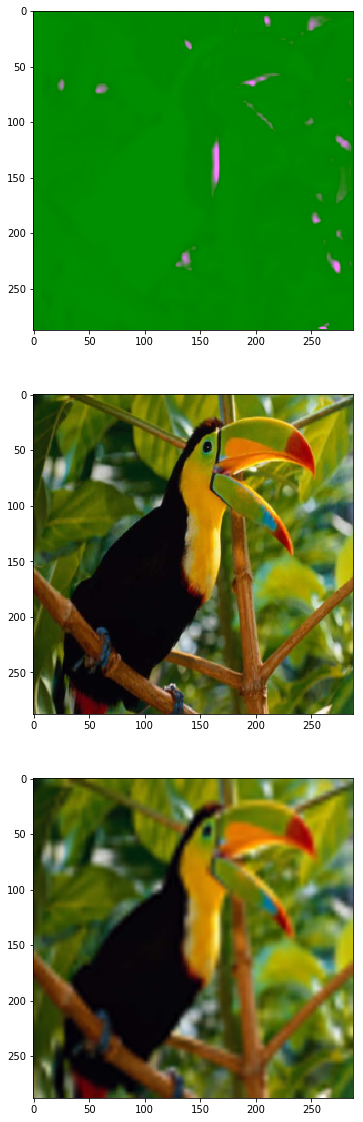

In [149]:
mypath = './data/Set5/image_SRF_4/img_002_SRF_4_HR.png'
value_truth=imread(mypath)
mypath = './data/Set5/image_SRF_4/img_002_SRF_4_LR.png'
value_pred=imread(mypath)
value_pred_bi=imresize(arr=value_pred,size=4.0,interp='bicubic')
value_pred=(value_pred_bi-127.5)/128
value_pred=np.reshape(value_pred,(1,value_pred.shape[0],value_pred.shape[1],value_pred.shape[2]))

value_pred=rgb2ycbcr(value_pred)
input_value = np.reshape(value_pred[:,:,:,0],(1,value_pred.shape[1],value_pred.shape[2],1))


predict_SR= G.predict(x=input_value)
#predict_SR=predict_SR*128+127.5
#predict_SR[predict_SR>255]=255
#predict_SR[predict_SR<0]=0

predict_SR.max()
#predict_SR=predict_SR.astype('uint8')

predict_SR=np.reshape(predict_SR,(predict_SR.shape[1],predict_SR.shape[2],1))
value_pred[0,:,:,:]=predict_SR

value_pred=np.reshape(value_pred,(value_pred.shape[1],value_pred.shape[2],3))
value_pred=ycbcr2rgb(value_pred)
value_pred=value_pred*255
value_pred[value_pred>255]=255
value_pred[value_pred<0]=0


plt.figure(figsize=(20,20))
plt.subplot(311)
plt.imshow(value_pred.astype('uint8'))
plt.subplot(312)
plt.imshow(value_truth.astype('uint8'))
plt.subplot(313)
plt.imshow(value_pred_bi.astype('uint8'))

plt.show()

In [146]:
value_pred

array([[[ 255.        ,  127.18317727,  255.        ],
        [ 255.        ,  128.35324811,  255.        ],
        [ 182.85876316,  129.64436077,  190.86172476],
        ..., 
        [   0.        ,  134.48603322,    0.        ],
        [   0.        ,  134.56672776,    0.        ],
        [   0.        ,  134.97020047,    0.        ]],

       [[ 255.        ,  127.86908087,  255.        ],
        [ 155.25465566,  130.04783347,  159.0455322 ],
        [  75.2027439 ,  131.21790431,   66.77857379],
        ..., 
        [   0.        ,  133.71943508,    0.        ],
        [   0.        ,  134.00186598,    0.        ],
        [   0.        ,  134.76846411,    0.        ]],

       [[ 255.        ,  128.51463719,  255.        ],
        [ 113.8484944 ,  130.65304253,  111.32124337],
        [  25.5153504 ,  131.94415518,    9.5094272 ],
        ..., 
        [   0.        ,  134.00186598,    0.        ],
        [   0.        ,  134.32464414,    0.        ],
        [   0.     